Baseline_TF
https://www.kaggle.com/code/ivaneleskin/baseline-tf

In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tqdm import tqdm
import json
import gc
from sklearn.model_selection import train_test_split
# import missingno as msno

from pathlib import Path

2023-02-27 14:03:29.116515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 14:03:29.263158: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-27 14:03:29.710801: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/victor/miniconda3/envs/tf/lib/:/home/victor/miniconda3/envs/tf/lib/:/home/victor/miniconda3/envs/tf/lib/:/home/victor/miniconda3/envs/tf/lib/
2023-02-27 14:03:29.710867: W tensorflow/stream_executor/platfo

In [2]:
DATA_ROOT = Path('..')
DF_TRAIN = DATA_ROOT / 'train.csv'
train = pd.read_csv(DF_TRAIN)

print("train.shape = {} rows, {} cols".format(*train.shape))
train.info()
train.head()


train.shape = 94477 rows, 4 cols
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            94477 non-null  object
 1   participant_id  94477 non-null  int64 
 2   sequence_id     94477 non-null  int64 
 3   sign            94477 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [3]:
class CFG:
    data_path = "../"
    quick_experiment = False
    is_training = True
    use_aggregation_dataset = True
    num_classes = 250
    rows_per_frame = 543 

def load_relevant_data_subset_with_imputation(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    data.replace(np.nan, 0, inplace=True)
    n_frames = int(len(data) / CFG.rows_per_frame)
    data = data.values.reshape(n_frames, CFG.rows_per_frame, len(data_columns))
    return data.astype(np.float32)

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / CFG.rows_per_frame)
    data = data.values.reshape(n_frames, CFG.rows_per_frame, len(data_columns))
    return data.astype(np.float32)

def read_dict(file_path):
    path = os.path.expanduser(file_path)
    with open(path, "r") as f:
        dic = json.load(f)
    return dic

In [4]:
train = pd.read_csv(f"{CFG.data_path}train.csv")
label_index = read_dict(f"{CFG.data_path}sign_to_prediction_index_map.json")
index_label = {label_index[key]: key for key in label_index}
train["label"] = train["sign"].map(lambda sign: label_index[sign])

In [5]:
if CFG.is_training:
    print('True')
#     if CFG.use_aggregation_dataset == True:
    try:
        X=  np.load('X_3d.npy')
        y= np.load('y_3d.npy')
    except:
        print('True')
        xs, ys = [], []
        num_frames = np.zeros(len(train))
        for i in tqdm(range(len(train))):
            path = f"{CFG.data_path}{train.iloc[i].path}"
            data = load_relevant_data_subset_with_imputation(path)
            ## Mean Aggregation
            xs.append(np.mean(data, axis=0))
            ys.append(train.iloc[i].label)
            num_frames[i] = data.shape[0]
            if CFG.quick_experiment and i == 4999:
                break
        ## Save number of frames of each training sample for data analysis
        train["num_frames"] = num_frames
        X, y = np.array(xs), np.array(ys)
        print(train["num_frames"].describe())
        train.to_csv("train.csv", index=False)
        np.save('X_3d.npy', X)
        np.save('y_3d.npy', y)

    print(X.shape, y.shape)

True
True


100%|████████████████████████████████████████████████████████████████████████| 94477/94477 [04:44<00:00, 331.52it/s]


count    94477.000000
mean        37.935021
std         44.177069
min          2.000000
25%         12.000000
50%         22.000000
75%         44.000000
max        537.000000
Name: num_frames, dtype: float64
(94477, 543, 3) (94477,)


In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.GRU(128, return_sequences=True, input_shape=[None,3]),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(250, activation="softmax"),
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=[
        "accuracy",
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top-5-accuracy"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10),
    ]
)

In [38]:
# if True:
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
#     print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
# #     del X, y
#     gc.collect()
# #     model = get_model()
#     callbacks = [
#         tf.keras.callbacks.ModelCheckpoint("model.h5"),
#         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,),
#     ]
#     history = model.fit(X_train, y_train, epochs=3, validation_data=(X_val, y_val), batch_size=128, callbacks=callbacks)
# else:
#     model = tf.keras.models.load_model("../model.h5")
# model.summary()

(75581, 543, 3) (75581,) (18896, 543, 3) (18896,)
Epoch 1/3
591/591 [==============================] - 45s 73ms/step - loss: 5.4264 - accuracy: 0.0078 - top-5-accuracy: 0.0349 - sparse_top_k_categorical_accuracy: 0.0647 - val_loss: 5.3057 - val_accuracy: 0.0102 - val_top-5-accuracy: 0.0470 - val_sparse_top_k_categorical_accuracy: 0.0927
Epoch 2/3
591/591 [==============================] - 43s 72ms/step - loss: 5.1683 - accuracy: 0.0191 - top-5-accuracy: 0.0776 - sparse_top_k_categorical_accuracy: 0.1379 - val_loss: 4.9814 - val_accuracy: 0.0247 - val_top-5-accuracy: 0.1055 - val_sparse_top_k_categorical_accuracy: 0.1839
Epoch 3/3
591/591 [==============================] - 42s 72ms/step - loss: 4.9008 - accuracy: 0.0322 - top-5-accuracy: 0.1246 - sparse_top_k_categorical_accuracy: 0.2067 - val_loss: 4.7861 - val_accuracy: 0.0392 - val_top-5-accuracy: 0.1445 - val_sparse_top_k_categorical_accuracy: 0.2405
Model: "sequential_1"
_____________________________________________________________

In [8]:
if True:
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
#     del X, y
    gc.collect()
#     model = get_model()
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint("model.h5"),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,),
    ]
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=128, callbacks=callbacks)
else:
    model = tf.keras.models.load_model("../model.h5")
model.summary()

(75581, 543, 3) (75581,) (18896, 543, 3) (18896,)
Epoch 1/50
591/591 [==============================] - 42s 71ms/step - loss: 5.2092 - accuracy: 0.0176 - top-5-accuracy: 0.0749 - sparse_top_k_categorical_accuracy: 0.1317 - val_loss: 5.0570 - val_accuracy: 0.0248 - val_top-5-accuracy: 0.1018 - val_sparse_top_k_categorical_accuracy: 0.1769
Epoch 2/50
591/591 [==============================] - 41s 69ms/step - loss: 4.8950 - accuracy: 0.0378 - top-5-accuracy: 0.1341 - sparse_top_k_categorical_accuracy: 0.2242 - val_loss: 4.7798 - val_accuracy: 0.0465 - val_top-5-accuracy: 0.1630 - val_sparse_top_k_categorical_accuracy: 0.2608
Epoch 3/50
591/591 [==============================] - 41s 70ms/step - loss: 4.5783 - accuracy: 0.0645 - top-5-accuracy: 0.2099 - sparse_top_k_categorical_accuracy: 0.3267 - val_loss: 4.5038 - val_accuracy: 0.0705 - val_top-5-accuracy: 0.2327 - val_sparse_top_k_categorical_accuracy: 0.3539
Epoch 4/50
591/591 [==============================] - 41s 70ms/step - loss: 4.34

591/591 [==============================] - 42s 70ms/step - loss: 2.2985 - accuracy: 0.4295 - top-5-accuracy: 0.7364 - sparse_top_k_categorical_accuracy: 0.8283 - val_loss: 2.5955 - val_accuracy: 0.3752 - val_top-5-accuracy: 0.6768 - val_sparse_top_k_categorical_accuracy: 0.7830
Epoch 30/50
591/591 [==============================] - 42s 71ms/step - loss: 2.2605 - accuracy: 0.4391 - top-5-accuracy: 0.7426 - sparse_top_k_categorical_accuracy: 0.8331 - val_loss: 2.5478 - val_accuracy: 0.3829 - val_top-5-accuracy: 0.6887 - val_sparse_top_k_categorical_accuracy: 0.7875
Epoch 31/50
591/591 [==============================] - 42s 71ms/step - loss: 2.2354 - accuracy: 0.4433 - top-5-accuracy: 0.7465 - sparse_top_k_categorical_accuracy: 0.8360 - val_loss: 2.5018 - val_accuracy: 0.3895 - val_top-5-accuracy: 0.7013 - val_sparse_top_k_categorical_accuracy: 0.7957
Epoch 32/50
591/591 [==============================] - 42s 71ms/step - loss: 2.2004 - accuracy: 0.4510 - top-5-accuracy: 0.7530 - sparse_to

In [9]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model_gru.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpog6t1yfz/assets


INFO:tensorflow:Assets written to: /tmp/tmpog6t1yfz/assets
2023-02-27 14:38:28.340376: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-02-27 14:38:28.340420: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-02-27 14:38:28.340997: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpog6t1yfz
2023-02-27 14:38:28.352956: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-02-27 14:38:28.352983: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpog6t1yfz
2023-02-27 14:38:28.390488: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-02-27 14:38:28.401479: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-02-27 14:38:28.497243: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

ConverterError: /home/victor/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/saved_model/save.py:1268:0: error: 'tf.TensorListReserve' op requires element_shape to be static during TF Lite transformation pass
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
/home/victor/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/saved_model/save.py:1268:0: error: failed to legalize operation 'tf.TensorListReserve' that was explicitly marked illegal
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: error: Lowering tensor list ops is failed. Please consider using Select TF ops and disabling `_experimental_lower_tensor_list_ops` flag in the TFLite converter object. For example, converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]\n converter._experimental_lower_tensor_list_ops = False


In [10]:
import matplotlib.pyplot as plt
import numpy as np

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'top-5-accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_accuracy', 'val_top-5-accuracy', 'val_sparse_top_k_categorical_accuracy'])


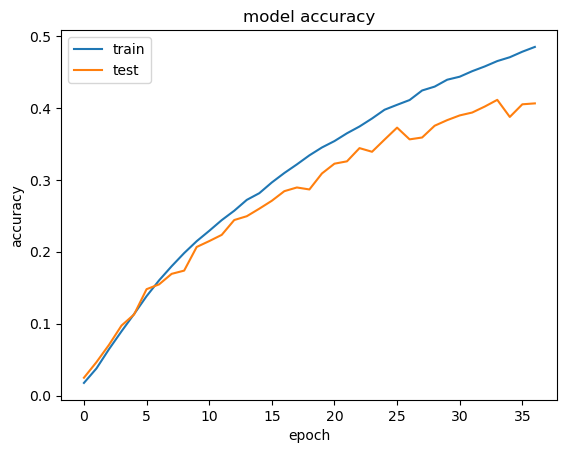

In [11]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

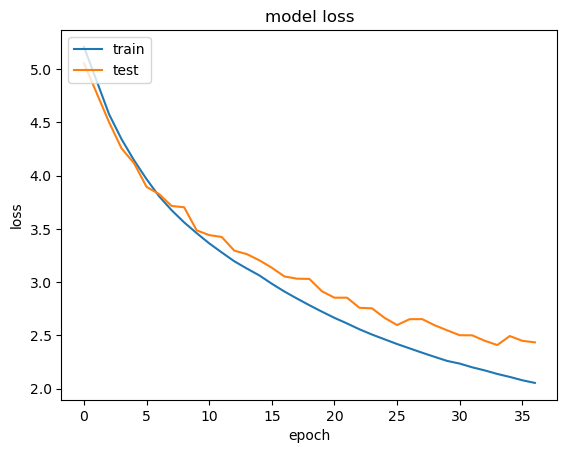

In [12]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
def get_model():
    return model

In [16]:
get_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 128)         51072     
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense (Dense)               (None, 250)               32250     
                                                                 
Total params: 182,394
Trainable params: 182,394
Non-trainable params: 0
_________________________________________________________________


In [28]:
inputs = tf.keras.Input((543, 3), dtype=tf.float32, name="inputs")
x = tf.where(tf.math.is_nan(inputs), tf.zeros_like(inputs), inputs)
x = tf.reduce_mean(x, axis=0, keepdims=True)

# for i in range(1, len(model.layers)):
x = model.layers[0](x)
x = model.layers[1](x)
x = model.layers[2](x)

In [29]:
def get_inference_model(model):
    inputs = tf.keras.Input((543, 3), dtype=tf.float32, name="inputs")
    x = tf.where(tf.math.is_nan(inputs), tf.zeros_like(inputs), inputs)
    x = tf.reduce_mean(x, axis=0, keepdims=True)
    
    for i in range(0, len(model.layers)):
        x = model.layers[i](x)
    output = tf.keras.layers.Activation(activation="linear", name="outputs")(x)
    inference_model = tf.keras.Model(inputs=inputs, outputs=output) 
    inference_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    
    return inference_model

In [30]:
inference_model = get_inference_model(model)
inference_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 543, 3)]     0           []                               
                                                                                                  
 tf.math.is_nan_6 (TFOpLambda)  (None, 543, 3)       0           ['inputs[0][0]']                 
                                                                                                  
 tf.zeros_like_6 (TFOpLambda)   (None, 543, 3)       0           ['inputs[0][0]']                 
                                                                                                  
 tf.where_6 (TFOpLambda)        (None, 543, 3)       0           ['tf.math.is_nan_6[0][0]',       
                                                                  'tf.zeros_like_6[0][0]',    

In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
tflite_model = converter.convert()
model_path = "model.tflite"
# Save the model.
with open(model_path, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpbc9au6v_/assets


INFO:tensorflow:Assets written to: /tmp/tmpbc9au6v_/assets
2023-02-27 14:47:56.181048: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-02-27 14:47:56.181087: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-02-27 14:47:56.181246: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbc9au6v_
2023-02-27 14:47:56.191118: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-02-27 14:47:56.191146: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbc9au6v_
2023-02-27 14:47:56.229278: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-02-27 14:47:56.296647: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbc9au6v_
2023-02-27 14:47:56.354540: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

In [35]:
import tflite_runtime.interpreter as tflite
interpreter = tflite.Interpreter(model_path)
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")
corr = 0
wrong = []
for i in tqdm(range(100)):
    frames = load_relevant_data_subset(f'../{train.iloc[i].path}')
    output = prediction_fn(inputs=frames)
    sign = np.argmax(output["outputs"])
    if index_label[sign] == train.iloc[i].sign:
        corr += 1
    else:
        wrong.append((index_label[sign], train.iloc[i].sign, train.iloc[i].path))

    #     print(f"Predicted label: {index_label[sign]}, Actual Label: {train.iloc[i].sign}")


    total = i

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.12it/s]


In [36]:
r = f'''
{total=}
{corr=}\t Percent: {corr/total:%}
'''
print(r)


total=99
corr=57	 Percent: 57.575758%



In [22]:
wrongs = pd.DataFrame(data=wrong, columns=['pred','true','path'])
wrongs.groupby('pred').count().reset_index().sort_values('true')

,pred,true,path
37,carrot,42,42
151,napkin,51,51
221,tomorrow,58,58
136,look,59,59
2,airplane,59,59
...,...,...,...
163,outside,478,478
5,animal,521,521
56,dance,583,583
236,weus,584,584


In [12]:
r = f'''
{total=}
{corr=}\t Percent: {corr/total:%}
'''
print(r)


total=94476
corr=41875	 Percent: 44.323426%



In [13]:
wrongs = pd.DataFrame(data=wrong, columns=['pred','true','path'])
wrongs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52602 entries, 0 to 52601
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pred    52602 non-null  object
 1   true    52602 non-null  object
 2   path    52602 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [14]:
wrongs.groupby('pred').count().reset_index().sort_values('true')

,pred,true,path
141,many,44,44
58,dog,46,46
212,talk,50,50
119,horse,52,52
161,open,53,53
...,...,...,...
35,can,539,539
208,story,608,608
224,toothbrush,663,663
109,haveto,692,692


In [12]:
r = f'''
{total=}
{corr=}\t Percent: {corr/total:%}
'''
print(r)


total=94476
corr=36349	 Percent: 38.474322%



In [13]:
wrongs = pd.DataFrame(data=wrong, columns=['pred','true','path'])
wrongs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58128 entries, 0 to 58127
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pred    58128 non-null  object
 1   true    58128 non-null  object
 2   path    58128 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB


In [14]:
wrongs.groupby('pred').count().reset_index().sort_values('true')

,pred,true,path
167,pen,23,23
130,lamp,32,32
204,stairs,50,50
207,store,51,51
131,later,52,52
...,...,...,...
225,touch,536,536
188,room,537,537
25,blow,555,555
173,please,565,565
